In [1]:
import torch_geometric

In [2]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

from torch.nn import Linear, LayerNorm, ReLU, Dropout
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader
from sklearn.metrics import accuracy_score,f1_score,roc_auc_score, precision_score, recall_score, confusion_matrix

import scipy.sparse as sp

import warnings
warnings.filterwarnings("ignore")
import pandas as pd
from sklearn.model_selection import train_test_split

import torch.nn.functional as F
from sklearn.metrics import roc_auc_score
from torch.nn import Linear
from torch_geometric.nn import GCNConv,GATConv,GATv2Conv


In [3]:
Download=True

In [4]:
FOLDERNAME='/Users/mayank/'

In [5]:
df_features = pd.read_csv(FOLDERNAME+'elliptic_txs_features.csv',header=None)
df_edges = pd.read_csv(FOLDERNAME+"elliptic_txs_edgelist.csv")
df_classes =  pd.read_csv(FOLDERNAME+"elliptic_txs_classes.csv")`

In [6]:
df_classes['class'] = df_classes['class'].map({'unknown': 2, '1':1, '2':0}) 

<BarContainer object of 3 artists>

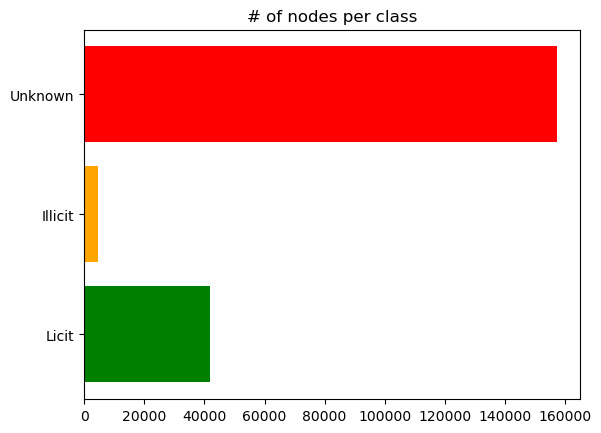

In [7]:
group_class = df_classes.groupby('class').count()
plt.title("# of nodes per class")
plt.barh([ 'Licit','Illicit', 'Unknown'], group_class['txId'].values, color=['g', 'orange', 'r'] )

In [8]:
df_features.head()

,0,1,2,3,4,5,6,7,8,9,...,157,158,159,160,161,162,163,164,165,166
0,230425980,1,-0.171469,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162097,...,-0.562153,-0.600999,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
1,5530458,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162112,...,0.947382,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
2,232022460,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162749,...,0.670883,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792
3,232438397,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,...,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792
4,230460314,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,-0.163523,...,-0.511871,-0.400422,0.517257,0.579382,0.018279,0.277775,0.326394,1.293750,0.178136,0.179117


In [9]:
df_edges.head()

,txId1,txId2
0,230425980,5530458
1,232022460,232438397
2,230460314,230459870
3,230333930,230595899
4,232013274,232029206


In [10]:
df_classes.head()

,txId,class
0,230425980,2
1,5530458,2
2,232022460,2
3,232438397,0
4,230460314,2


In [11]:
df_merge = df_features.merge(df_classes, how='left', right_on="txId", left_on=0)
df_merge = df_merge.sort_values(0).reset_index(drop=True)
df_merge.head()

,0,1,2,3,4,5,6,7,8,9,...,159,160,161,162,163,164,165,166,txId,class
0,1076,48,-0.168500,0.270909,-0.091383,-0.046932,-0.043875,-0.029140,-0.061584,-0.163591,...,1.461330,1.461369,0.018279,0.470019,1.216796,1.151607,1.519700,1.521399,1076,2
1,2534,6,-0.170834,-0.131425,1.018602,0.028105,0.055376,0.054722,-0.061584,-0.163572,...,0.955101,0.459257,-0.098889,-0.087490,-0.099080,-0.122137,-0.379970,-0.379288,2534,0
2,3181,34,1.305212,-0.210553,-1.756361,-0.121970,97.300650,-0.113002,-0.061584,1.348765,...,0.059948,0.113967,-0.098889,1.969527,0.037532,-0.131010,0.006994,0.017772,3181,0
3,3321,1,-0.169615,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.160199,...,0.241128,0.241406,-0.098889,-0.087490,-0.084674,-0.140597,1.519700,1.521399,3321,2
4,3889,48,-0.086232,-0.101835,-0.646376,-0.121970,17.046997,-0.113002,-0.061584,-0.074885,...,0.082065,0.114773,-0.098889,8.948005,1.024948,-0.009570,-0.080708,-0.123601,3889,2


In [12]:
# Setup trans ID to node ID mapping
nodes = df_merge[0].values

map_id = {j:i for i,j in enumerate(nodes)} # mapping nodes to indexes

# Create edge df that has transID mapped to nodeIDs
edges = df_edges.copy()
edges.txId1 = edges.txId1.map(map_id) #get nodes idx1 from edges list and filtered data
edges.txId2 = edges.txId2.map(map_id)

edges = edges.astype(int)

edge_index = np.array(edges.values).T #convert into an array
edge_index = torch.tensor(edge_index, dtype=torch.long).contiguous() # create a tensor

print("shape of edge index is {}".format(edge_index.shape))
edge_index


shape of edge index is torch.Size([2, 234355])


tensor([[138670, 141325, 139232,  ..., 100420,  54833, 101159],
        [  4142, 142201, 139223,  ..., 100419,  81951, 101163]])

In [13]:
weights = torch.tensor([1]* edge_index.shape[1] , dtype=torch.double) 

In [14]:
labels = df_merge['class'].values
print("lables", np.unique(labels))
labels

lables [0 1 2]


array([2, 0, 0, ..., 2, 2, 2])

In [15]:
# mapping txIds to corresponding indices, to pass node features to the model

node_features = df_merge.drop(['txId'], axis=1).copy()
# node_features[0] = node_features[0].map(map_id) # Convert transaction ID to node ID \
print("unique=",node_features["class"].unique())

# Retain known vs unknown IDs
classified_idx = node_features['class'].loc[node_features['class']!=2].index # filter on known labels
unclassified_idx = node_features['class'].loc[node_features['class']==2].index

classified_illicit_idx = node_features['class'].loc[node_features['class']==1].index # filter on illicit labels
classified_licit_idx = node_features['class'].loc[node_features['class']==0].index # filter on licit labels

# Drop unwanted columns, 0 = transID, 1=time period, class = labels
node_features = node_features.drop(columns=[0, 1, 'class'])

# Convert to tensor
node_features_t = torch.tensor(np.array(node_features.values, dtype=np.double), dtype=torch.double)# drop unused columns
node_features_t

unique= [2 0 1]


tensor([[-0.1685,  0.2709, -0.0914,  ...,  1.1516,  1.5197,  1.5214],
        [-0.1708, -0.1314,  1.0186,  ..., -0.1221, -0.3800, -0.3793],
        [ 1.3052, -0.2106, -1.7564,  ..., -0.1310,  0.0070,  0.0178],
        ...,
        [-0.1727, -0.1588, -1.2014,  ..., -0.2698, -0.1206, -0.1198],
        [-0.1727, -0.1588, -1.2014,  ..., -0.2698, -0.1206, -0.1198],
        [-0.1433, -0.1588, -1.2014,  ..., -0.0975, -0.1206, -0.1198]],
       dtype=torch.float64)

In [16]:
node_features

,2,3,4,5,6,7,8,9,10,11,...,157,158,159,160,161,162,163,164,165,166
0,-0.168500,0.270909,-0.091383,-0.046932,-0.043875,-0.029140,-0.061584,-0.163591,-0.164980,-0.009283,...,0.073047,-0.039637,1.461330,1.461369,0.018279,0.470019,1.216796,1.151607,1.519700,1.521399
1,-0.170834,-0.131425,1.018602,0.028105,0.055376,0.054722,-0.061584,-0.163572,-0.167757,-0.038545,...,1.228858,0.379357,0.955101,0.459257,-0.098889,-0.087490,-0.099080,-0.122137,-0.379970,-0.379288
2,1.305212,-0.210553,-1.756361,-0.121970,97.300650,-0.113002,-0.061584,1.348765,1.321754,-0.049707,...,1.348450,1.590664,0.059948,0.113967,-0.098889,1.969527,0.037532,-0.131010,0.006994,0.017772
3,-0.169615,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.160199,-0.166062,-0.049707,...,-0.577099,-0.500080,0.241128,0.241406,-0.098889,-0.087490,-0.084674,-0.140597,1.519700,1.521399
4,-0.086232,-0.101835,-0.646376,-0.121970,17.046997,-0.113002,-0.061584,-0.074885,-0.081943,-0.049707,...,0.501062,0.362510,0.082065,0.114773,-0.098889,8.948005,1.024948,-0.009570,-0.080708,-0.123601
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203764,-0.172978,-0.172527,0.463609,-0.121970,-0.043875,-0.113002,-0.061584,-0.163640,-0.169455,-0.049707,...,-0.577099,-0.600999,0.241128,0.241406,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
203765,-0.172669,-0.158783,-1.201369,-0.121970,-0.063725,-0.113002,-0.061584,-0.163323,-0.169142,-0.049707,...,-0.577099,-0.626229,0.241128,0.241406,-0.216057,-0.125939,-0.131155,-0.269818,-0.120613,-0.119792
203766,-0.172669,-0.158783,-1.201369,-0.121970,-0.063725,-0.113002,-0.061584,-0.163323,-0.169142,-0.049707,...,-0.577099,-0.626229,0.241128,0.241406,-0.216057,-0.125939,-0.131155,-0.269818,-0.120613,-0.119792
203767,-0.172669,-0.158783,-1.201369,-0.121970,-0.063725,-0.113002,-0.061584,-0.163323,-0.169142,-0.049707,...,-0.577099,-0.626229,0.241128,0.241406,-0.216057,-0.125939,-0.131155,-0.269818,-0.120613,-0.119792


In [17]:
train_idx, valid_idx = train_test_split(classified_idx.values, test_size=0.15)
print("train_idx size {}".format(len(train_idx)))
print("tets_idx size {}".format(len(valid_idx)))

train_idx size 39579
tets_idx size 6985


In [18]:
data_train = Data(x=node_features_t, edge_index=edge_index, edge_attr=weights, 
                               y=torch.tensor(labels, dtype=torch.double))
# Add in the train and valid idx
data_train.train_idx = train_idx
data_train.valid_idx = valid_idx
data_train.test_idx = unclassified_idx

In [19]:
import torch
import torch_scatter
import torch.nn as nn
import torch.nn.functional as F

import torch_geometric.nn as pyg_nn
import torch_geometric.utils as pyg_utils

from torch import Tensor
from typing import Union, Tuple, Optional
from torch_geometric.typing import (OptPairTensor, Adj, Size, NoneType,
                                    OptTensor)

from torch.nn import Parameter, Linear
from torch_sparse import SparseTensor, set_diag
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.utils import remove_self_loops, add_self_loops, softmax, degree

from torch_geometric.nn import GCNConv,GATConv,GATv2Conv
import pickle

In [20]:

class GATv2(torch.nn.Module):
    def __init__(self,input_dim, hidden_dim, output_dim,args):
        super(GATv2, self).__init__()
        #use our gat message passing 
        self.conv1 = GATv2Conv(input_dim, hidden_dim, heads=args['heads'])
        self.conv2 = GATv2Conv(args['heads'] * hidden_dim, hidden_dim, heads=args['heads'])
        
        self.post_mp = nn.Sequential(
            nn.Linear(args['heads'] * hidden_dim, hidden_dim), nn.Dropout(args['dropout'] ), 
            nn.Linear(hidden_dim, output_dim))
        
    def forward(self, data, adj=None):
        x, edge_index = data.x, data.edge_index
        # Layer 1
        x = self.conv1(x, edge_index)
        x = F.dropout(F.relu(x), p=args['dropout'], training=self.training)
        # Layer 2
        x = self.conv2(x, edge_index)
        x = F.dropout(F.relu(x), p=args['dropout'], training=self.training)
        # MLP output
        x = self.post_mp(x)
        return F.sigmoid(x)


In [21]:
class GnnTrainer(object):
  
  def __init__(self, model):
    self.model = model
    self.metric_manager = MetricManager(modes=["train", "val"])

  def train(self, data_train, optimizer, criterion, scheduler, args):
  
    self.data_train = data_train
    for epoch in range(args['epochs']):
        self.model.train()
        optimizer.zero_grad()
        out = self.model(data_train)

        out = out.reshape((data_train.x.shape[0]))
        loss = criterion(out[data_train.train_idx], data_train.y[data_train.train_idx])
        ## Metric calculations
        # train data
        target_labels = data_train.y.detach().cpu().numpy()[data_train.train_idx]
        pred_scores = out.detach().cpu().numpy()[data_train.train_idx]
        train_acc, train_f1,train_f1macro, train_aucroc, train_recall, train_precision, train_cm = self.metric_manager.store_metrics("train", pred_scores, target_labels)


        ## Training Step
        loss.backward()
        optimizer.step()

        # validation data
        self.model.eval()
        target_labels = data_train.y.detach().cpu().numpy()[data_train.valid_idx]
        pred_scores = out.detach().cpu().numpy()[data_train.valid_idx]
        val_acc, val_f1,val_f1macro, val_aucroc, val_recall, val_precision, val_cm = self.metric_manager.store_metrics("val", pred_scores, target_labels)

        if epoch%5 == 0:
          print("epoch: {} - loss: {:.4f} - accuracy train: {:.4f} -accuracy valid: {:.4f}  - val roc: {:.4f}  - val f1micro: {:.4f}".format(epoch, loss.item(), train_acc, val_acc, val_aucroc,val_f1))

  # To predict labels
  def predict(self, data=None, unclassified_only=True, threshold=0.5):
    # evaluate model:
    self.model.eval()
    if data is not None:
      self.data_train = data

    out = self.model(self.data_train)
    out = out.reshape((self.data_train.x.shape[0]))

    if unclassified_only:
      pred_scores = out.detach().cpu().numpy()[self.data_train.test_idx]
    else:
      pred_scores = out.detach().cpu().numpy()

    pred_labels = pred_scores > threshold

    return {"pred_scores":pred_scores, "pred_labels":pred_labels}

  # To save metrics
  def save_metrics(self, save_name, path="./save/"):
    file_to_store = open(path + save_name, "wb")
    pickle.dump(self.metric_manager, file_to_store)
    file_to_store.close()
  
  # To save model
  def save_model(self, save_name, path="./save/"):
    torch.save(self.model.state_dict(), path + save_name)

In [22]:
class MetricManager(object):
  def __init__(self, modes=["train", "val"]):

    self.output = {}

    for mode in modes:
      self.output[mode] = {}
      self.output[mode]["accuracy"] = []
      self.output[mode]["f1micro"] = []
      self.output[mode]["f1macro"] = []
      self.output[mode]["aucroc"] = []
      #new
      self.output[mode]["precision"] = []
      self.output[mode]["recall"] = []
      self.output[mode]["cm"] = []

  def store_metrics(self, mode, pred_scores, target_labels, threshold=0.5):

    # calculate metrics
    pred_labels = pred_scores > threshold
    accuracy = accuracy_score(target_labels, pred_labels)
    f1micro = f1_score(target_labels, pred_labels,average='micro')
    f1macro = f1_score(target_labels, pred_labels,average='macro')
    aucroc = roc_auc_score(target_labels, pred_scores)
    #new
    recall = recall_score(target_labels, pred_labels)
    precision = precision_score(target_labels, pred_labels)
    cm = confusion_matrix(target_labels, pred_labels)

    # Collect results
    self.output[mode]["accuracy"].append(accuracy)
    self.output[mode]["f1micro"].append(f1micro)
    self.output[mode]["f1macro"].append(f1macro)
    self.output[mode]["aucroc"].append(aucroc)
    #new
    self.output[mode]["recall"].append(recall)
    self.output[mode]["precision"].append(precision)
    self.output[mode]["cm"].append(cm)
    
    return accuracy, f1micro,f1macro, aucroc,recall,precision,cm
  
  # Get best results
  def get_best(self, metric, mode="val"):

    # Get best results index
    best_results = {}
    i = np.array(self.output[mode][metric]).argmax()

    # Output
    for m in self.output[mode].keys():
      best_results[m] = self.output[mode][m][i]
    
    return best_results

In [23]:
# Set training arguments, set prebuild=True to use builtin PyG models otherwise False
args={"epochs":100,
      'lr':0.01,
      'weight_decay':1e-5,
      'prebuild':True,
      'heads':2,
      'hidden_dim': 128, 
      'dropout': 0.5
      }

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [24]:
model = GATv2(data_train.num_node_features, args['hidden_dim'], 1, args)
model.double().to(device)
# Push data to GPU
data_train = data_train.to(device)

# Setup training settings
optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'], weight_decay=args['weight_decay'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
criterion = torch.nn.BCELoss()
# Train
gnn_trainer_gatv2 = GnnTrainer(model)
gnn_trainer_gatv2.train(data_train, optimizer, criterion, scheduler, args)

gnn_trainer_gatv2.save_metrics("GATv2prebuilt.results", path=FOLDERNAME + "/save_results/")
gnn_trainer_gatv2.save_model("GATv2prebuilt.pth", path=FOLDERNAME + "/save_results/")

epoch: 0 - loss: 0.7359 - accuracy train: 0.5253 -accuracy valid: 0.5261  - val roc: 0.5063  - val f1micro: 0.5261
epoch: 5 - loss: 0.2545 - accuracy train: 0.9028 -accuracy valid: 0.8999  - val roc: 0.8878  - val f1micro: 0.8999
epoch: 10 - loss: 0.2136 - accuracy train: 0.9028 -accuracy valid: 0.8999  - val roc: 0.9119  - val f1micro: 0.8999
epoch: 15 - loss: 0.1710 - accuracy train: 0.9028 -accuracy valid: 0.8999  - val roc: 0.9398  - val f1micro: 0.8999
epoch: 20 - loss: 0.1558 - accuracy train: 0.9036 -accuracy valid: 0.9004  - val roc: 0.9475  - val f1micro: 0.9004
epoch: 25 - loss: 0.1409 - accuracy train: 0.9341 -accuracy valid: 0.9286  - val roc: 0.9553  - val f1micro: 0.9286
epoch: 30 - loss: 0.1247 - accuracy train: 0.9637 -accuracy valid: 0.9572  - val roc: 0.9596  - val f1micro: 0.9572
epoch: 35 - loss: 0.1108 - accuracy train: 0.9696 -accuracy valid: 0.9636  - val roc: 0.9604  - val f1micro: 0.9636
epoch: 40 - loss: 0.0996 - accuracy train: 0.9707 -accuracy valid: 0.9635 

KeyboardInterrupt: 

In [25]:
gnn_trainer_gatv2.save_metrics("", path=FOLDERNAME + "desktop/finalresultsmetric")
gnn_trainer_gatv2.save_model("", path=FOLDERNAME + "desktop/finalresultsmodel")

In [26]:
mmGATprebuilt = pickle.load(open(FOLDERNAME + "desktop/finalresultsmetric", "rb"))
mmGATprebuilt.get_best("aucroc")


{'accuracy': 0.9736578382247674,
 'f1micro': 0.9736578382247674,
 'f1macro': 0.9219695221905166,
 'aucroc': 0.9773120274998555,
 'precision': 0.9284525790349417,
 'recall': 0.7982832618025751,
 'cm': array([[6243,   43],
        [ 141,  558]])}

In [27]:
import plotly.express as px
import plotly.graph_objects as go

# Validation accuracy comparisons
def plot_training_comp(metric_manager_list, names, metric="aucroc", version="val",title="Val set accuracy comparison"):

  fig = go.Figure()
  fig = fig.update_layout(title=title,
                          xaxis_title="Epoch",
                          yaxis_title=metric)

  for i, metric_manager in enumerate(metric_manager_list):
    epochs = np.arange(len(metric_manager.output[version][metric]))
    fig.add_trace(go.Scatter(x=epochs,
                             y=metric_manager.output[version][metric],
                             name=names[i]))
  fig.show()

# Load saved outputs
def load_results(fn):
  mm1 = pickle.load(open(FOLDERNAME + "desktop/finalresultsmetric", "rb"))
  return mm1


In [32]:
# Compare GAT vs GATv2 with 2 heads, prebuilt PyGs models 
plot_training_comp([mmGATprebuilt], ["GATv2" ],"f1micro",title="Val set f1micro")  
plot_training_comp([mmGATprebuilt], ["GATv2" ],"accuracy",title="Val set accuracy")  
plot_training_comp([mmGATprebuilt], ["GATv2" ],"f1macro",title="Val set f1macro")
plot_training_comp([mmGATprebuilt], ["GATv2" ],"aucroc",title="Val set aucroc")  
 


In [34]:
import networkx as nx
import matplotlib.pyplot as plt

# Load one model 
m1 = GATv2(data_train.num_node_features, args['hidden_dim'], 1, args).to(device).double()
m1.load_state_dict(torch.load(FOLDERNAME + "desktop/finalresultsmodel"))
gnn_t2 = GnnTrainer(m1)
output = gnn_t2.predict(data=data_train, unclassified_only=False)
output


{'pred_scores': array([7.65067374e-04, 2.59634321e-05, 0.00000000e+00, ...,
        4.39222341e-37, 1.00000000e+00, 9.70623099e-05]),
 'pred_labels': array([False, False, False, ..., False,  True, False])}

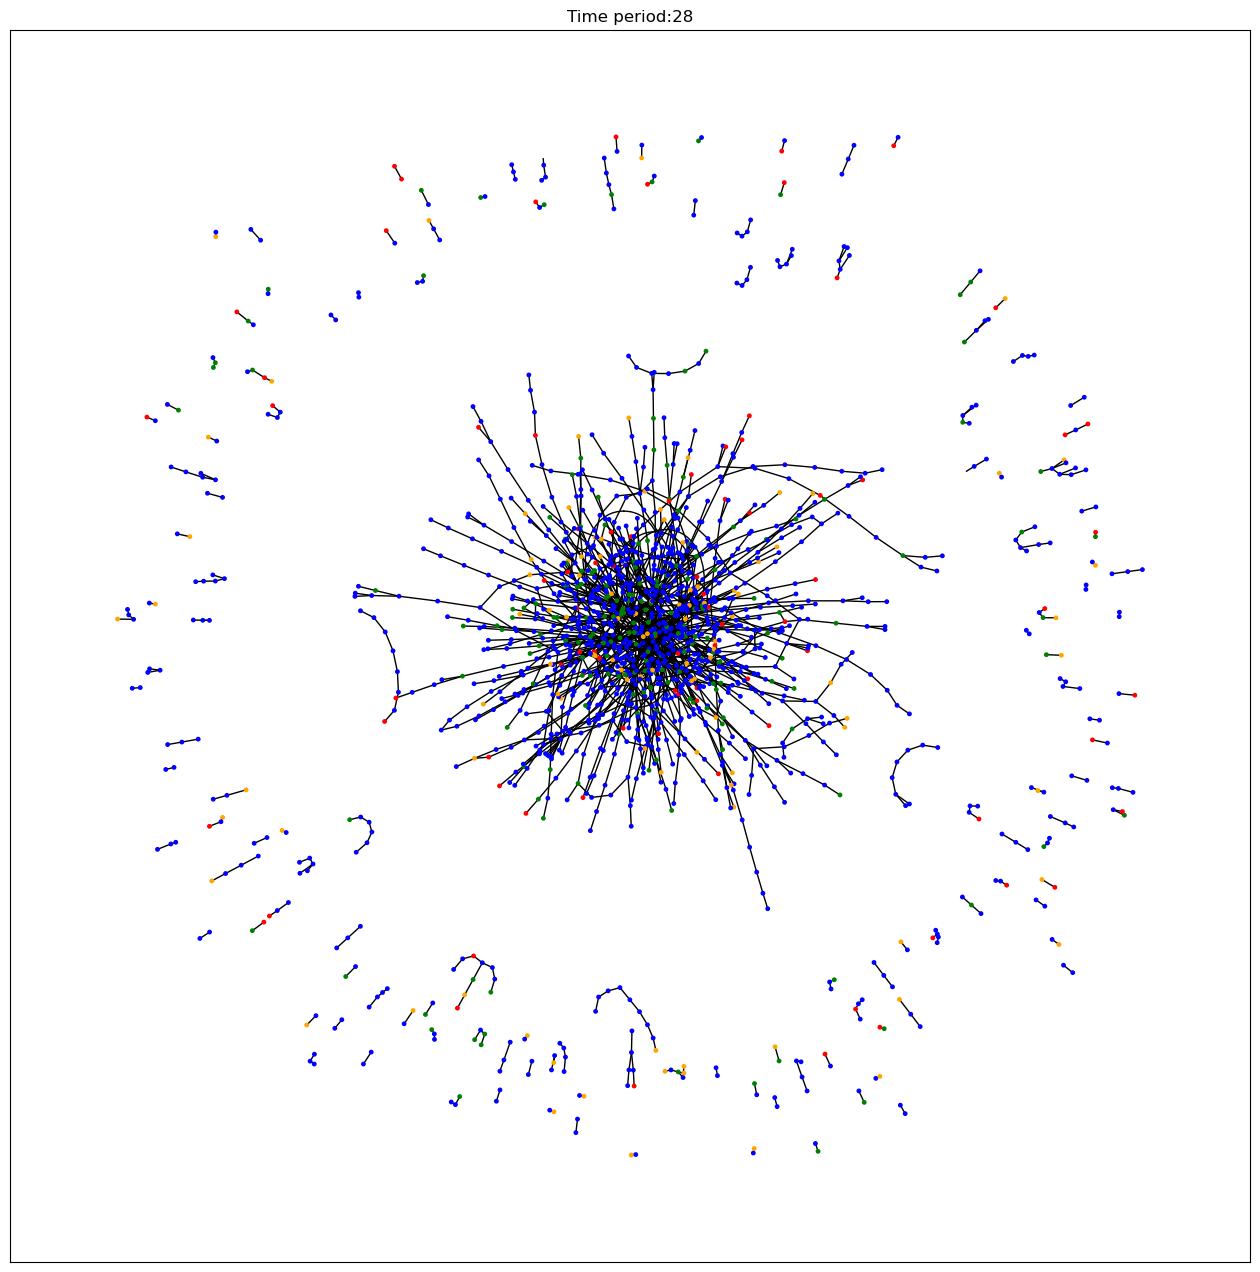

In [35]:
# Get index for one time period
time_period = 28
sub_node_list = df_merge.index[df_merge.loc[:, 1] == time_period].tolist()

# Fetch list of edges for that time period
edge_tuples = []
for row in data_train.edge_index.view(-1, 2).numpy():
  if (row[0] in sub_node_list) | (row[1] in sub_node_list):
    edge_tuples.append(tuple(row))
len(edge_tuples)

# Fetch predicted results for that time period
node_color = []
for node_id in sub_node_list:
  if node_id in classified_illicit_idx: # 
     label = "red" # fraud
  elif node_id in classified_licit_idx:
     label = "green" # not fraud
  else:
    if output['pred_labels'][node_id]:
      label = "orange" # Predicted fraud
    else:
      label = "blue" # Not fraud predicted 
  
  node_color.append(label)

# Setup networkx graph
G = nx.Graph()
G.add_edges_from(edge_tuples)

# Plot the graph
plt.figure(3,figsize=(16,16)) 
plt.title("Time period:"+str(time_period))
nx.draw_networkx(G, nodelist=sub_node_list, node_color=node_color, node_size=6, with_labels=False)